# This notebook contains examples to illustrate the below meta learners:

- Transformed Outcome
- S-learner
- T-learner
- X-Learner

**The dataset used is about an email campaign where customers of an investment firm are sent emails asking them to subscribe to a financial product**

The dataset contains the below columns:
- **Age**: The age of the customer.
- **Income**: The income of the customer.
- **Invested**: The invested amount by the customer.
- **Email**: whether the campaign email has been sent to the customer. 1 if yes, 0 otherwise.
- **Converted**: whether the customer converted by subscribing to the product. 1 if yes, 0 otherwise.

In [1]:
# Import libraries

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.model_selection import train_test_split

from causalml.metrics import *

In [2]:
# Load the email campaign data.
# Data taken from github.com/matheusfacure/python-causality-handbook/

email = pd.read_csv('EmailCampaign.csv')

In [3]:
email.head()

,Age,Income,Insurance,Invested,Email,Converted
0,44.1,5483.80,6155.29,14294.81,0,0
1,39.8,2737.92,50069.40,7468.15,1,0
2,49.0,2712.51,5707.08,5095.65,1,1
3,39.7,2326.37,15657.97,6345.20,1,0
4,35.3,2787.26,27074.44,14114.86,1,0


In [4]:
# Split the data into train and test

np.random.seed(123)

train, test = train_test_split(email, test_size=0.4)

print(train.shape, test.shape)

(9000, 6) (6000, 6)


In [5]:
Y = "Converted"
T = "Email"
X = ["Age", "Income", "Insurance", "Invested"]

# Transformed Outcome

$Y^*_i = Y_i * \dfrac{T_i - PS_i}{PS_i(1-PS_i)}$

$E[Y^*_i|X_i=x] = CATE(x_i)$

In [6]:
# Calculate Propensity Score

propensity = train[T].mean()

# Transform the outcome on the train data

transformedY = train[Y] * (train[T] - propensity)/(propensity*(1-propensity))

In [7]:
# Initialise a desired regressor

np.random.seed(123)

transformedLearner = LGBMRegressor(max_depth=3, min_child_samples=300, num_leaves=5)

In [8]:
# Fit the regressor on the train data

transformedLearner.fit(train[X], transformedY)

LGBMRegressor(max_depth=3, min_child_samples=300, num_leaves=5)

In [9]:
# Calculate the CATE on the test set

test['CATE'] = transformedLearner.predict(test[X])

In [10]:
test.head()

,Age,Income,Insurance,Invested,Email,Converted,CATE
6958,40.9,4486.14,37320.33,12559.25,0,0,0.105665
7534,42.6,6386.19,13270.47,29114.42,0,0,0.121922
2975,47.6,1900.26,25588.72,2420.39,0,0,0.034161
3903,41.0,5802.19,57087.37,20182.20,1,1,0.046805
8437,49.1,2202.96,5050.81,9245.88,1,0,-0.009099


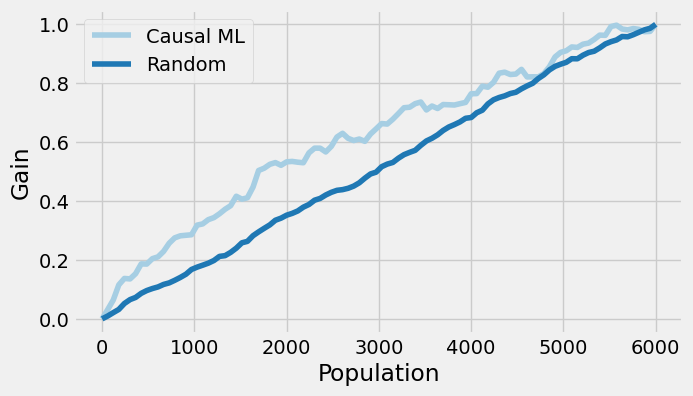

In [11]:
# Plot the gain curve

plot_gain(test[['Converted', 'Email', 'CATE']].rename(columns = {'CATE': 'Causal ML'}), outcome_col=Y, treatment_col=T, normalize=True, figsize=(7,4))

In [12]:
# Get the area under the curve

auuc_score(test[['Converted', 'Email', 'CATE']], outcome_col=Y, treatment_col=T)

CATE      0.615960
Random    0.513755
dtype: float64

# S-Learner

$\mu(x) = E[Y| T, X]$

$CATE(x_i) = M_s(X_i, T=1) - M_s(X_i, T=0)$

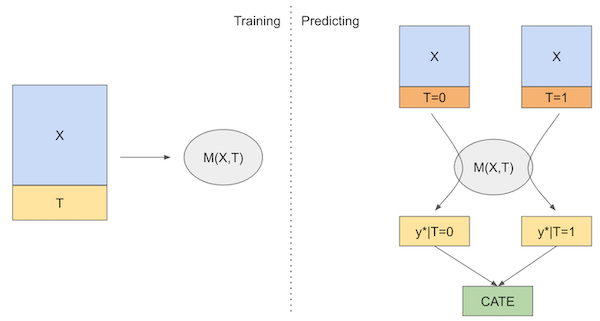

In [13]:
# Import the base class for the S learner

from causalml.inference.meta import BaseSRegressor

In [14]:
# Call the base learner and feed in XGB

SLearner = BaseSRegressor(XGBRegressor())

In [15]:
# Estimate the average treatment effect

ate = SLearner.estimate_ate(X=email[X], treatment=email[T], y=email[Y])

print('ATE estimate using S-Learner : {:.03f}'.format(ate[0]))

ATE estimate using S-Learner : 0.063


In [16]:
# Fit the learner on the train data

SLearner.fit(train[X], y=train[Y], treatment=train[T])

In [17]:
# Calculate the CATE on the test set

test['CATE'] = SLearner.predict(test[X])

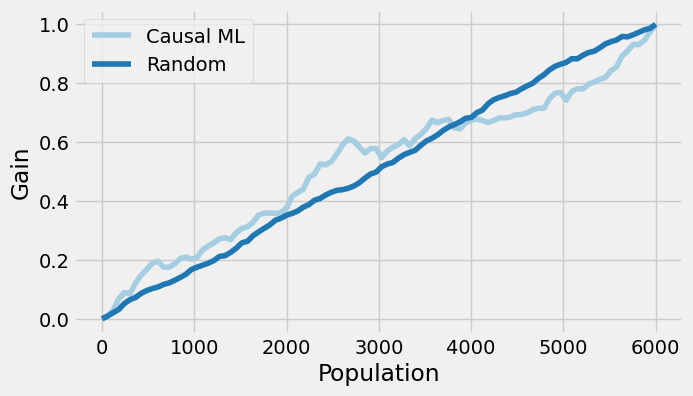

In [18]:
# Plot the gain curve

plot_gain(test[['Converted', 'Email', 'CATE']].rename(columns = {'CATE': 'Causal ML'}), outcome_col=Y, treatment_col=T, normalize=True, figsize=(7,4))

In [19]:
# Get the area under the curve

auuc_score(test[['Converted', 'Email', 'CATE']], outcome_col=Y, treatment_col=T)

CATE      0.525222
Random    0.513755
dtype: float64

# T-Learner

$\mu_0(x) = E[Y| T=0, X]$

$\mu_1(x) = E[Y| T=1, X]$

$CATE(x_i) = M_1(X_i) - M_0(X_i)$

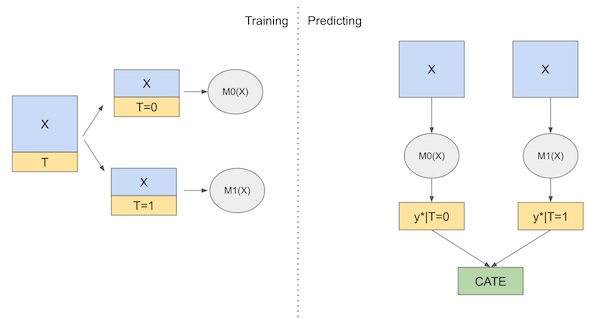

In [20]:
# Import the base class for the T learner

from causalml.inference.meta import BaseTRegressor

In [21]:
# Call the base learner and feed in XGB

TLearner = BaseTRegressor(XGBRegressor())

In [22]:
# Estimate the average treatment effect

ate = TLearner.estimate_ate(X=email[X], treatment=email[T], y=email[Y])

print('ATE estimate using T-Learner : {:.03f}'.format(ate[0][0]))

ATE estimate using T-Learner : 0.068


In [23]:
# Fit the learner on the train data

TLearner.fit(train[X], y=train[Y], treatment=train[T])

In [24]:
# Calculate the CATE on the test set

test['CATE'] = TLearner.predict(test[X])

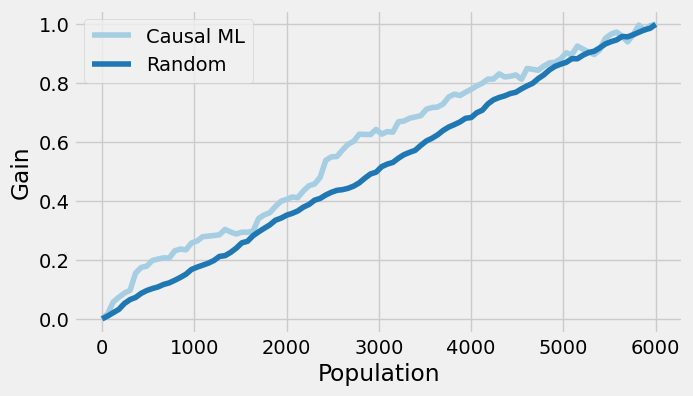

In [25]:
# Plot the gain curve

plot_gain(test[['Converted', 'Email', 'CATE']].rename(columns = {'CATE': 'Causal ML'}), outcome_col=Y, treatment_col=T, normalize=True, figsize=(7,4))

In [26]:
# Get the area under the curve

auuc_score(test[['Converted', 'Email', 'CATE']], outcome_col=Y, treatment_col=T)

CATE      0.581629
Random    0.513755
dtype: float64

# X-Learner

In [27]:
# Import the base class for the X learner

from causalml.inference.meta import BaseXRegressor

In [28]:
# Call the base learner and feed in XGB

XLearner = BaseXRegressor(learner=XGBRegressor())

In [29]:
# Estimate the average treatment effect

ate = XLearner.estimate_ate(X=email[X], treatment=email[T], y=email[Y])

print('ATE estimate using X-Learner : {:.03f}'.format(ate[0][0]))

ATE estimate using X-Learner : 0.069


In [30]:
# Fit the learner on the train data

XLearner.fit(train[X], y=train[Y], treatment=train[T])

In [31]:
# Calculate the CATE on the test set

test['CATE'] = XLearner.predict(test[X])

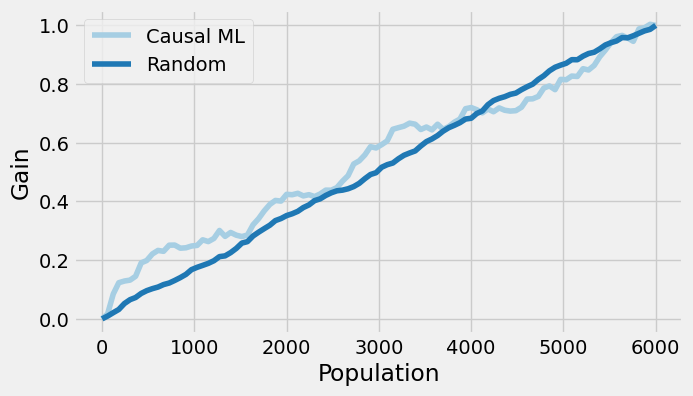

In [32]:
# Plot the gain curve

plot_gain(test[['Converted', 'Email', 'CATE']].rename(columns = {'CATE': 'Causal ML'}), outcome_col=Y, treatment_col=T, normalize=True, figsize=(7,4))

In [33]:
# Get the area under the curve

auuc_score(test[['Converted', 'Email', 'CATE']], outcome_col=Y, treatment_col=T)

CATE      0.546417
Random    0.513755
dtype: float64